In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../data/Superstore.csv', encoding='latin1')


In [4]:
df = data.copy()

In [9]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)
df.set_index('Order_Date', inplace=True)


In [10]:
monthly_sales = df['Sales'].resample('M').sum()

C:\Users\POWER\AppData\Local\Temp\ipykernel_26460\3660319126.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Sales'].resample('M').sum()


In [24]:
print(monthly_sales.head())

Order_Date
2015-01-31    14205.707
2015-02-28     4519.892
2015-03-31    55205.797
2015-04-30    27906.855
2015-05-31    23644.303
Freq: ME, Name: Sales, dtype: float64


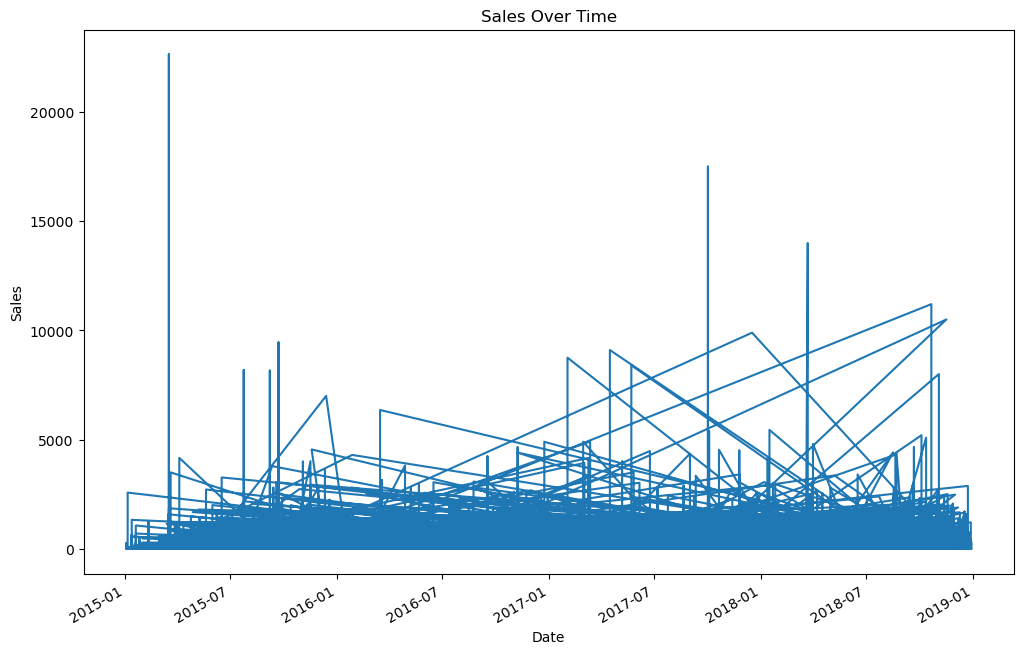

In [15]:
df['Sales'].plot(figsize=(12,8))
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

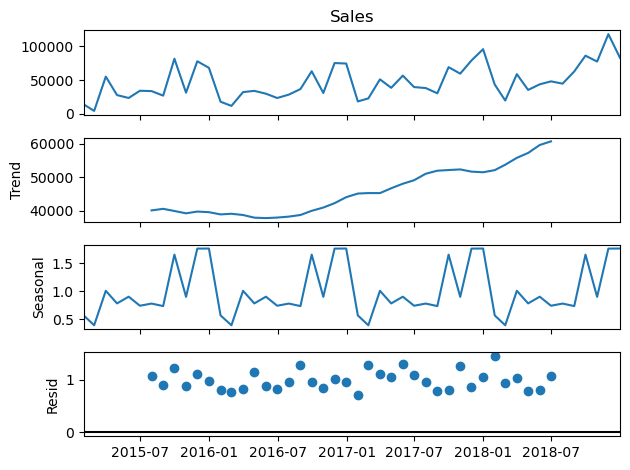

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

multiplicative = seasonal_decompose(monthly_sales, model='multiplicative')
multiplicative.plot()
plt.show()


In [20]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(monthly_sales)
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])


ADF Statistic: -4.416136761430769
p-value: 0.00027791039276670623


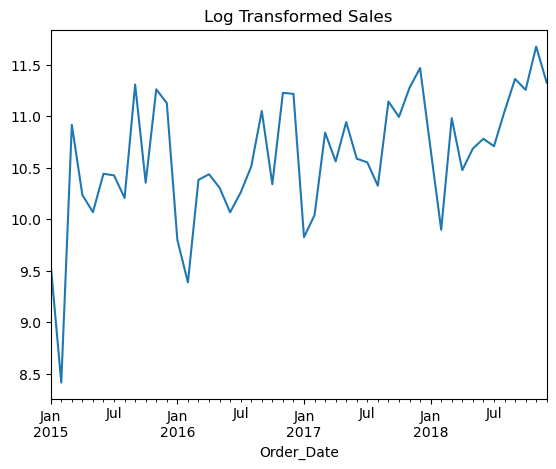

In [27]:
log_sales = np.log(monthly_sales)
log_sales.plot(title="Log Transformed Sales")
plt.show()

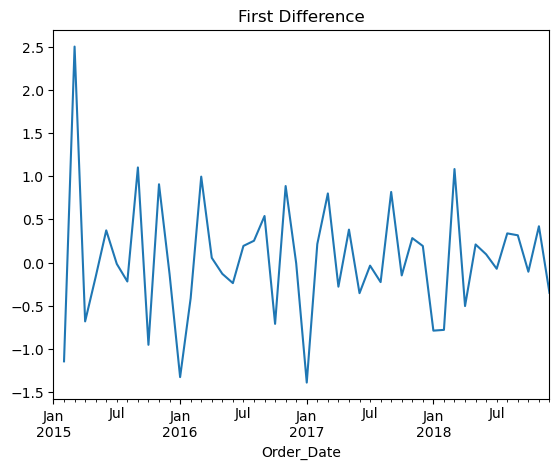

In [28]:
diff1 = log_sales.diff()
diff1.plot(title="First Difference")
plt.show()


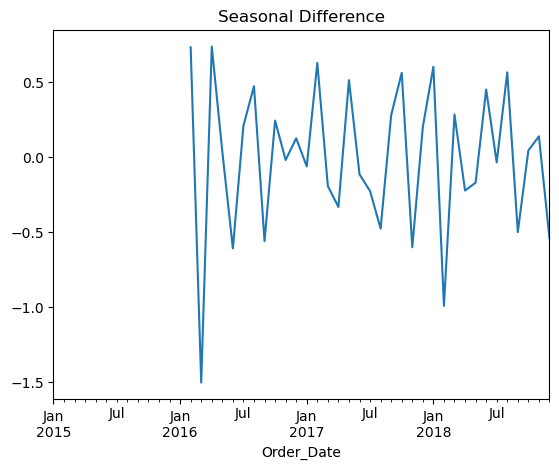

In [29]:
seasonal_diff = diff1.diff(12)
seasonal_diff.plot(title="Seasonal Difference")
plt.show()


In [32]:
adf = adfuller(seasonal_diff.dropna())
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])



ADF Statistic: -4.0426330404199105
p-value: 0.0012030094900734715


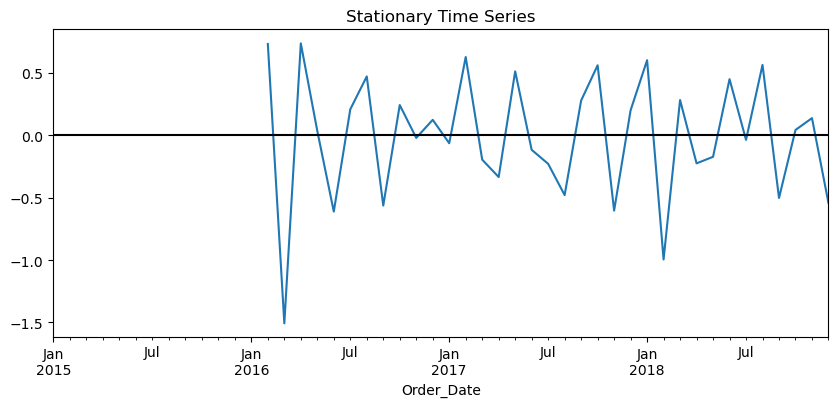

In [34]:
seasonal_diff.plot(figsize=(10,4))
plt.axhline(0, color='black')
plt.title("Stationary Time Series")
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(seasonal_diff.dropna(), lags=36)
plot_pacf(seasonal_diff.dropna(), lags=36)
plt.show()


In [37]:
stationary_series = seasonal_diff.dropna()


In [38]:
max_lags = min(36, len(stationary_series)//2)


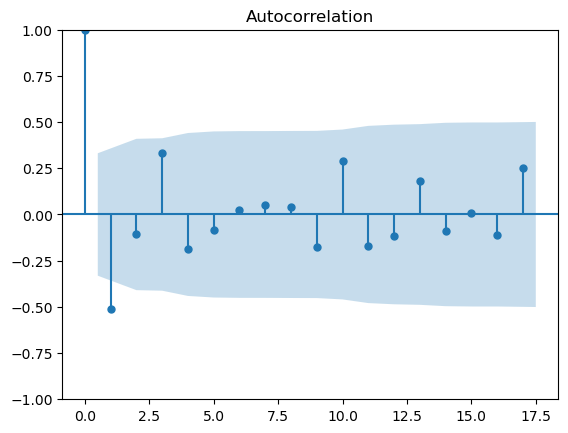

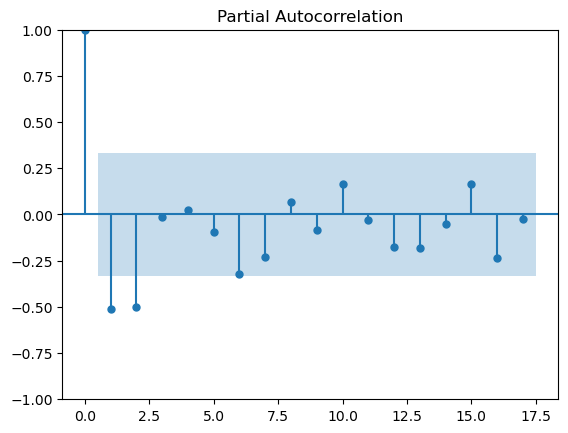

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(stationary_series, lags=max_lags)
plot_pacf(stationary_series, lags=max_lags)
plt.show()



In [40]:
train = monthly_sales.iloc[:-12]
test = monthly_sales.iloc[-12:]


In [42]:
p = 1
d = 1
q = 1

P = 1
D = 1
Q = 1
s = 12


In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,1,12))


results = model.fit()
print(results.summary())



                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -250.933
Date:                              Fri, 09 Jan 2026   AIC                            507.867
Time:                                      14:56:44   BIC                            511.273
Sample:                                  01-31-2015   HQIC                           508.724
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2675      0.179     -1.498      0.134      -0.618       0.082
ma.S.L12      -0.33

c:\Users\POWER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [51]:
forecast = results.get_forecast(steps=12)
pred = forecast.predicted_mean


In [52]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, pred)
print("MAE:", mae)


MAE: 15280.289754843625
